In [1]:
# Standard libraries
import os
import sys
import json
import random
import logging
import numpy as np
import matplotlib.pyplot as plt

# Third-party libraries
from tqdm import tqdm
from torchsummary import summary

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

# PyTorch learning rate schedulers
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# PyTorch utilities
from torchvision.utils import make_grid

# Project-specific modules
from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *
from model_analysis import *

# Load in Data Paths and Functions

In [2]:
# get PARCtorch path
path = os.path.abspath(os.path.join(os.getcwd(), "..")) 
print(path)

# Add the root directory (PARCTorch) to the system path
sys.path.append(path)
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
from data.normalization import compute_min_max

# Get single void HMX data
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(path, "data", "hmx_min_max.json")  # Correct path

/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch
Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 91
Processed 91/91 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, 0.0, 0.0]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7200.339, 7200.339]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


### Load in Test Data

In [3]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-08-21 14:24:46,423 [INFO] Starting data validation...
2025-08-21 14:24:46,427 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 362.27it/s]
2025-08-21 14:24:46,527 [INFO] Data validation completed successfully.
2025-08-21 14:24:46,528 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 380.23it/s]
2025-08-21 14:24:46,620 [INFO] Total samples in dataset: 33


In [4]:
n_samples = 33  # crashes with all 33 samples now
all_X = []

for sample_id in range(n_samples):
    ic, _, ts, target = test_dataset[sample_id]
    ic = ic[:n_channels, ...]                   
    target = target[:, :n_channels, ...]         

    X = torch.concat((ic.unsqueeze(0), target))
    all_X.append(X)

all_X = torch.stack(all_X, dim=0)
print(all_X.shape)

torch.Size([33, 15, 3, 128, 256])


Calculating PHATE...
  Running PHATE on 495 observations and 98304 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.42 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 4.45 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.42 seconds.
Calculated PHATE in 4.95 seconds.


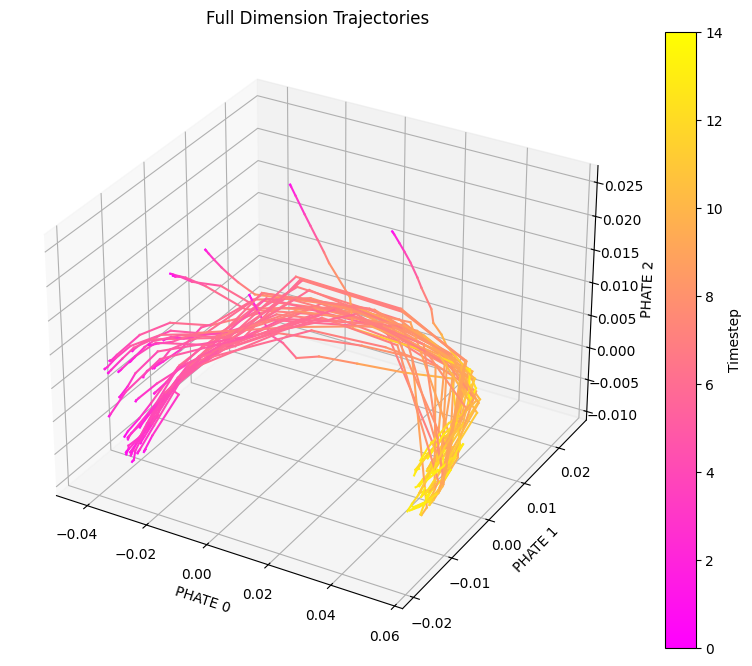

In [29]:
import numpy as np
import phate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example shapes
data = all_X

# ---- Reshape for PHATE ----
# Each state = one timestep of one sample flattened to a vector
X = data.reshape(n_samples * n_ts, -1)   # shape = [n_samples*n_ts, C*H*W]

# ---- Run PHATE ----
phate_op = phate.PHATE(n_components=3)
X_phate = phate_op.fit_transform(X)      # shape = [n_samples*n_ts, 3]

# ---- Organize back into trajectories ----
X_phate = X_phate.reshape(n_samples, n_ts, 3)

# ---- Plot trajectories ----
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Color by timestep
colors = plt.cm.spring(np.linspace(0, 1, n_ts))

for i in range(n_samples):
    traj = X_phate[i]
    for t in range(n_ts - 1):
        ax.plot(
            traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2],
            color=colors[t]
        )

# Make a colorbar for timesteps
sm = plt.cm.ScalarMappable(cmap="spring", norm=plt.Normalize(vmin=0, vmax=n_ts-1))
cbar = plt.colorbar(sm, ax=ax)  
cbar.set_label("Timestep")

ax.set_xlabel("PHATE 0")
ax.set_ylabel("PHATE 1")
ax.set_zlabel("PHATE 2")
ax.set_title("Full Dimension Trajectories")

plt.show()

Running PHATE for channel 0...
Calculating PHATE...
  Running PHATE on 495 observations and 32768 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.77 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 2.82 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...


/home/pdy2bw/.local/lib/python3.10/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 0 and 15. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated metric MDS in 3.63 seconds.
Calculated PHATE in 6.58 seconds.
Running PHATE for channel 1...
Calculating PHATE...
  Running PHATE on 495 observations and 32768 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 2.58 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...


/home/pdy2bw/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 115 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/pdy2bw/.local/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


  Calculated metric MDS in 0.81 seconds.
Calculated PHATE in 3.51 seconds.
Running PHATE for channel 2...
Calculating PHATE...
  Running PHATE on 495 observations and 32768 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 2.86 seconds.
  Calculating optimal t...


/home/pdy2bw/.local/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 4043 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/home/pdy2bw/.local/lib/python3.10/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Automatically selected t = 54
  Calculated optimal t in 0.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.27 seconds.
Calculated PHATE in 5.25 seconds.


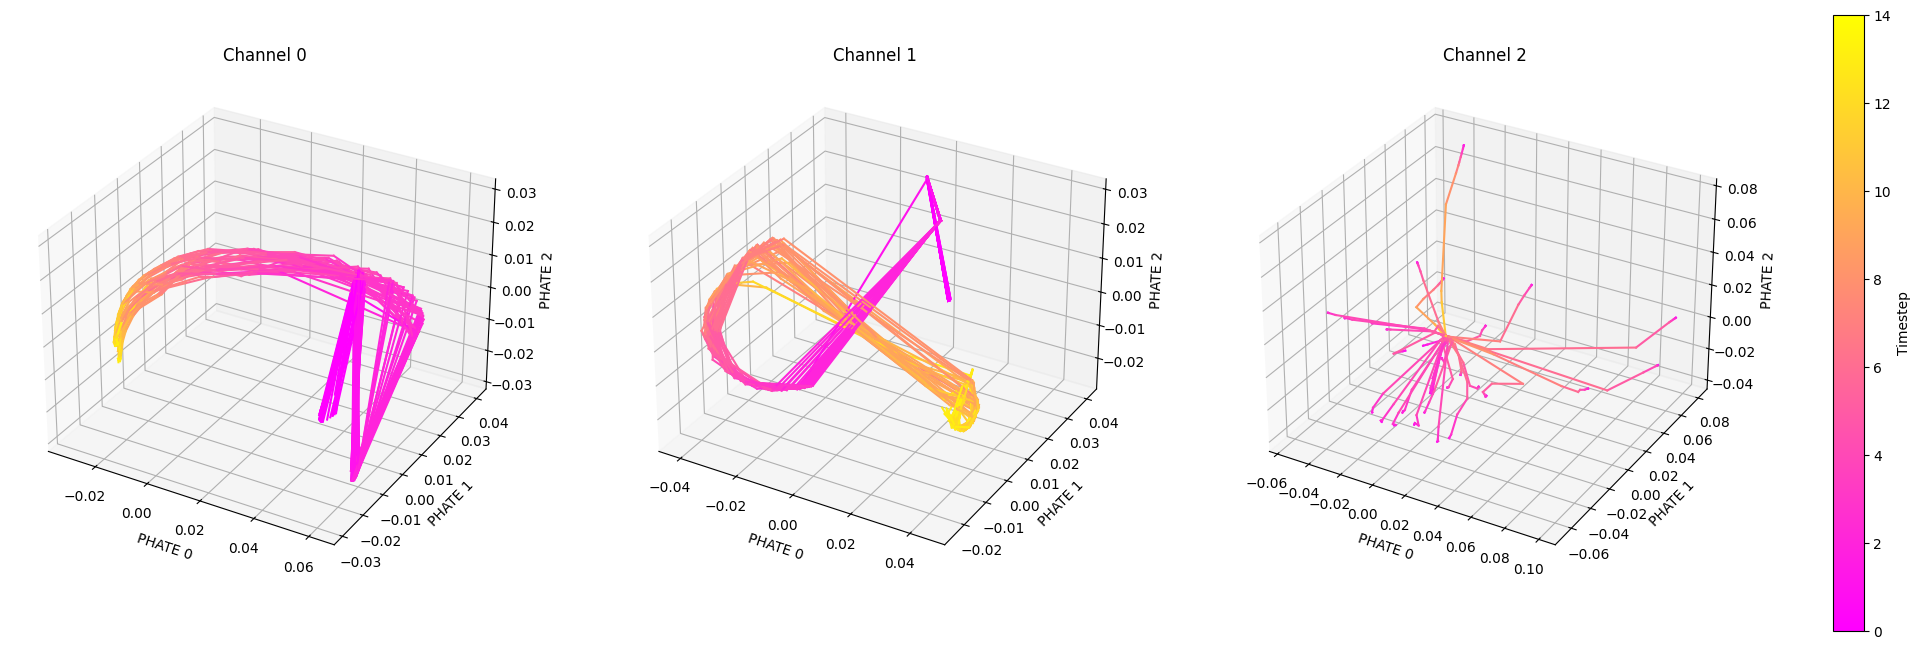

In [14]:
import numpy as np
import phate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: data shape [n_samples, n_ts, n_channels, H, W]
data = all_X
n_samples, n_ts, n_channels, H, W = data.shape

fig, axs = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

colors = plt.cm.spring(np.linspace(0, 1, n_ts))

for c in range(n_channels):
    print(f"Running PHATE for channel {c}...")
    
    # ---- Extract single channel ----
    channel_data = data[:, :, c, :, :]   # [n_samples, n_ts, H, W]
    
    # ---- Reshape for PHATE ----
    X = channel_data.reshape(n_samples * n_ts, -1)  # [n_samples*n_ts, H*W]
    
    # ---- Run PHATE ----
    phate_op = phate.PHATE(n_components=3)
    X_phate = phate_op.fit_transform(X)  # [n_samples*n_ts, 3]
    
    # ---- Organize back into trajectories ----
    X_phate = X_phate.reshape(n_samples, n_ts, 3)
    
    ax = axs[c]
    for i in range(n_samples):
        traj = X_phate[i]
        for t in range(n_ts - 1):
            ax.plot(
                traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2],
                color=colors[t]
            )
    
    ax.set_xlabel("PHATE 0")
    ax.set_ylabel("PHATE 1")
    ax.set_zlabel("PHATE 2")
    ax.set_title(f"Channel {c}")

# Shared colorbar on the right
sm = plt.cm.ScalarMappable(cmap="spring", norm=plt.Normalize(vmin=0, vmax=n_ts-1))
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.05, label="Timestep")

plt.show()


# Load in Autoencoder

In [5]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8]
latent_dim = 8
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# training model
model = ConvolutionalAutoencoder(autoencoder, optimizer, device)

In [6]:
device

device(type='cpu')

In [7]:
weights_path = "autoencoder/02_layers_and_latent_experiment/layers_3_8_latent_8_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"

# Map to CPU
state_dict = torch.load(weights_path, map_location=torch.device('cpu'))

# Load into model
model.network.load_state_dict(state_dict)
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_588113/1616723562.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device('cpu'))


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
)

In [16]:
# # GPU version
# # load weights into model
# weights_path = "autoencoder/02_layers_and_latent_experiment/layers_3_8_latent_8_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"

# model.network.load_state_dict(torch.load(weights_path))
# model.network.eval()  # Set to evaluation mode

### Encode Test Data

In [8]:
all_Z = []

for j in range(n_samples):
    all_test_images = all_X[j, ...]
    all_reconstructed_images = []
    
    for i in range(n_ts):
        with torch.no_grad():
            img = all_test_images[i, ...].unsqueeze(0).to(device)  # Move image to same device
            reconstructed_img = model.network.encoder(img)
        all_reconstructed_images.append(reconstructed_img.cpu())  # move output back to CPU

    # Concatenate all batches to create single tensors
    all_reconstructed_images = torch.cat(all_reconstructed_images, dim=0)
    all_Z.append(all_reconstructed_images)
    
all_Z = torch.stack(all_Z, dim=0)
all_Z.shape

torch.Size([33, 15, 8, 32, 64])

Calculating PHATE...
  Running PHATE on 495 observations and 16384 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.23 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 1.25 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.06 seconds.
Calculated PHATE in 2.39 seconds.


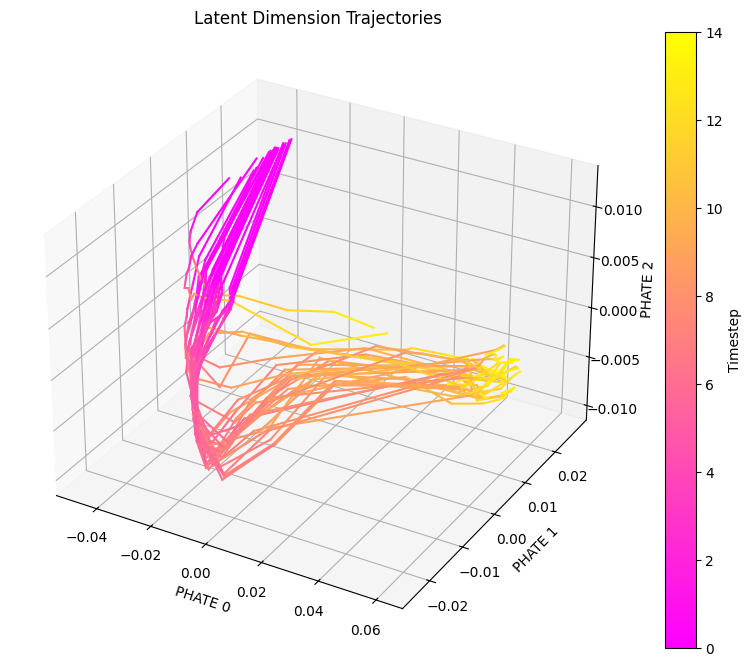

In [28]:
import numpy as np
import phate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example shapes
data = all_Z

# ---- Reshape for PHATE ----
# Each state = one timestep of one sample flattened to a vector
Z = data.reshape(n_samples * n_ts, -1)   # shape = [n_samples*n_ts, C*H*W]

# ---- Run PHATE ----
phate_op = phate.PHATE(n_components=3)
Z_phate = phate_op.fit_transform(Z)      # shape = [n_samples*n_ts, 3]

# ---- Organize back into trajectories ----
Z_phate = Z_phate.reshape(n_samples, n_ts, 3)

# ---- Plot trajectories ----
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Color by timestep
colors = plt.cm.spring(np.linspace(0, 1, n_ts))

for i in range(n_samples):
    traj = Z_phate[i]
    for t in range(n_ts - 1):
        ax.plot(
            traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2],
            color=colors[t]
        )

# Make a colorbar for timesteps
sm = plt.cm.ScalarMappable(cmap="spring", norm=plt.Normalize(vmin=0, vmax=n_ts-1))
cbar = plt.colorbar(sm, ax=ax)  
cbar.set_label("Timestep")

ax.set_xlabel("PHATE 0")
ax.set_ylabel("PHATE 1")
ax.set_zlabel("PHATE 2")
ax.set_title("Latent Dimension Trajectories")

plt.show()

Running PHATE for channel 0...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.27 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.90 seconds.
Calculated PHATE in 2.30 seconds.


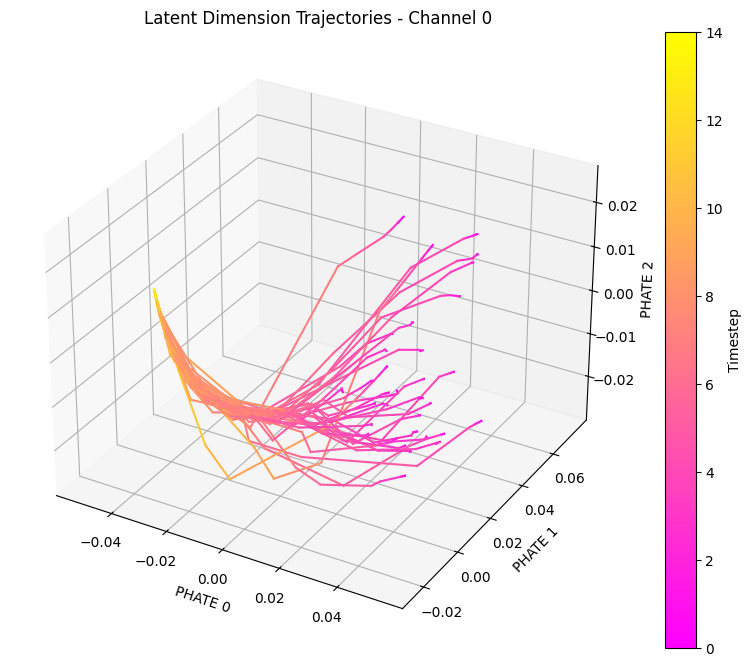

Running PHATE for channel 1...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 45
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.25 seconds.
Calculated PHATE in 4.56 seconds.


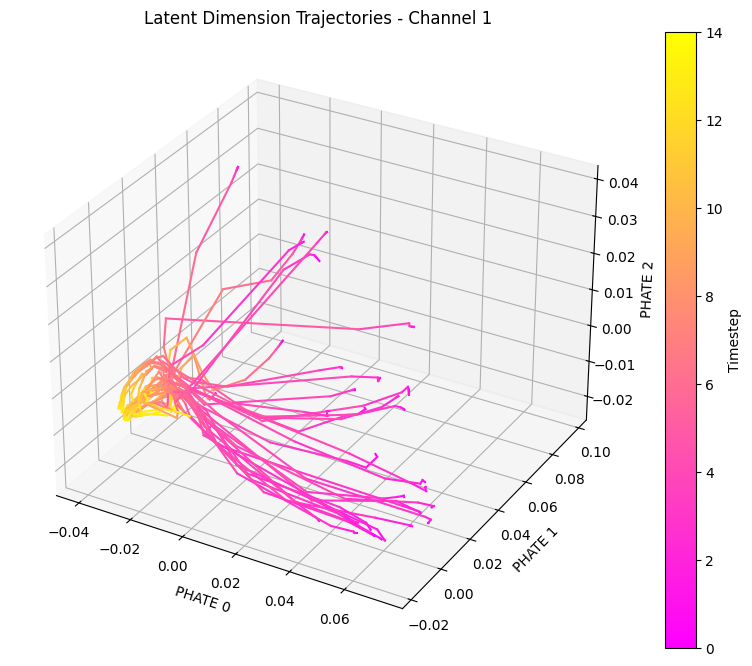

Running PHATE for channel 2...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.20 seconds.
  Calculating optimal t...
    Automatically selected t = 44
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.85 seconds.
Calculated PHATE in 2.17 seconds.


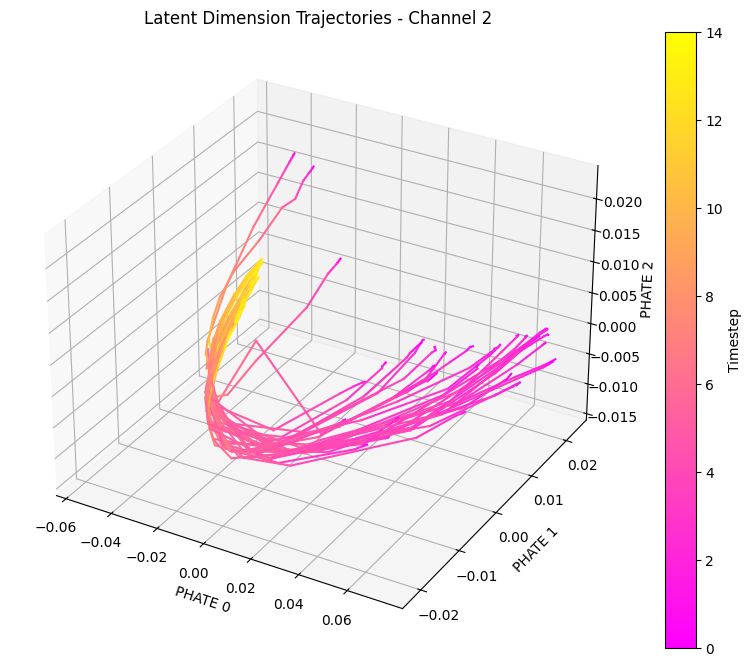

Running PHATE for channel 3...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.16 seconds.
Calculated PHATE in 2.47 seconds.


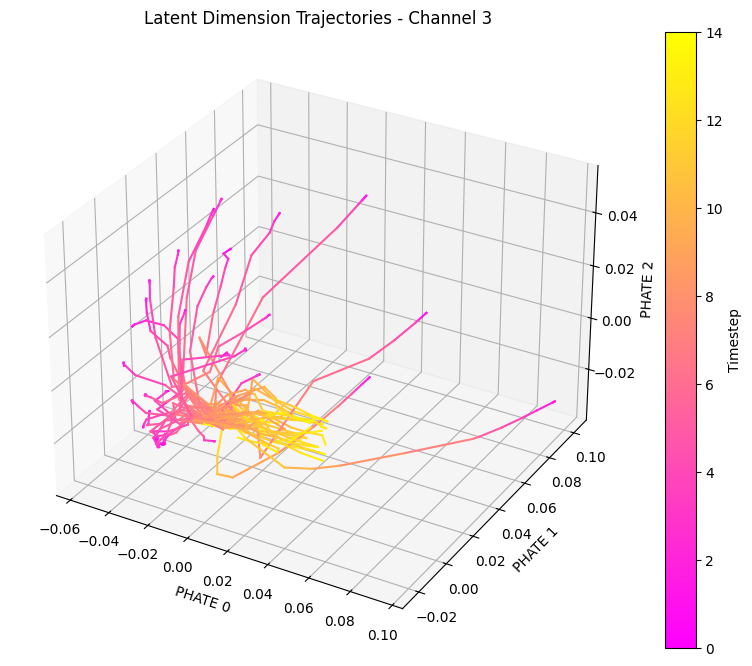

Running PHATE for channel 4...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.51 seconds.
Calculated PHATE in 2.81 seconds.


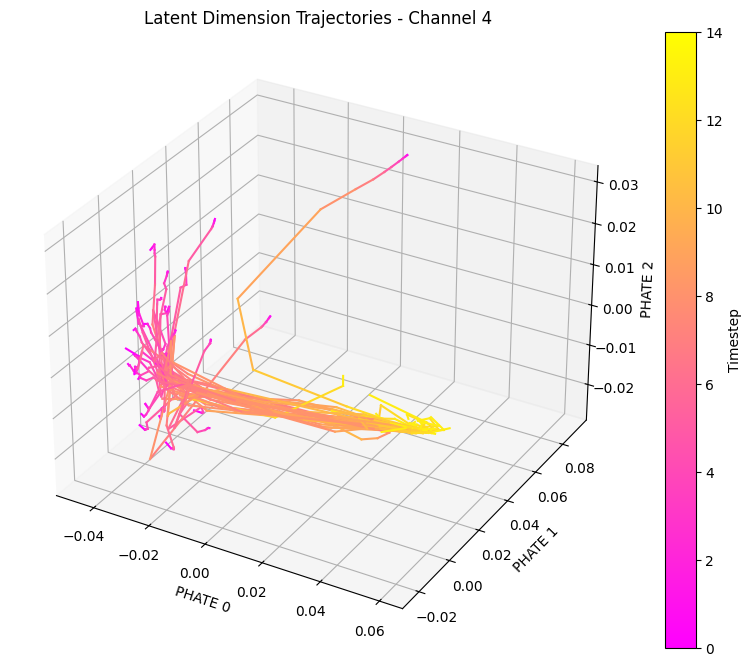

Running PHATE for channel 5...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 37
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.28 seconds.
Calculated PHATE in 1.59 seconds.


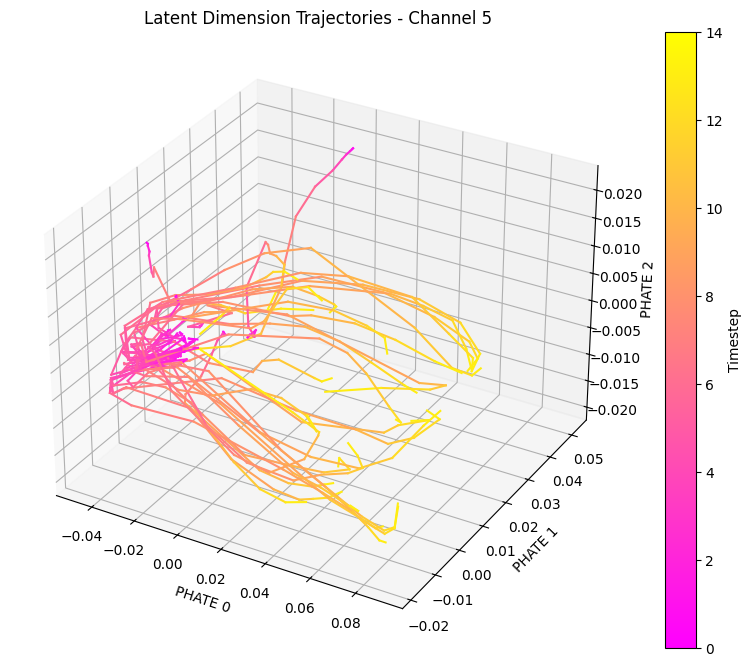

Running PHATE for channel 6...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.46 seconds.
Calculated PHATE in 1.76 seconds.


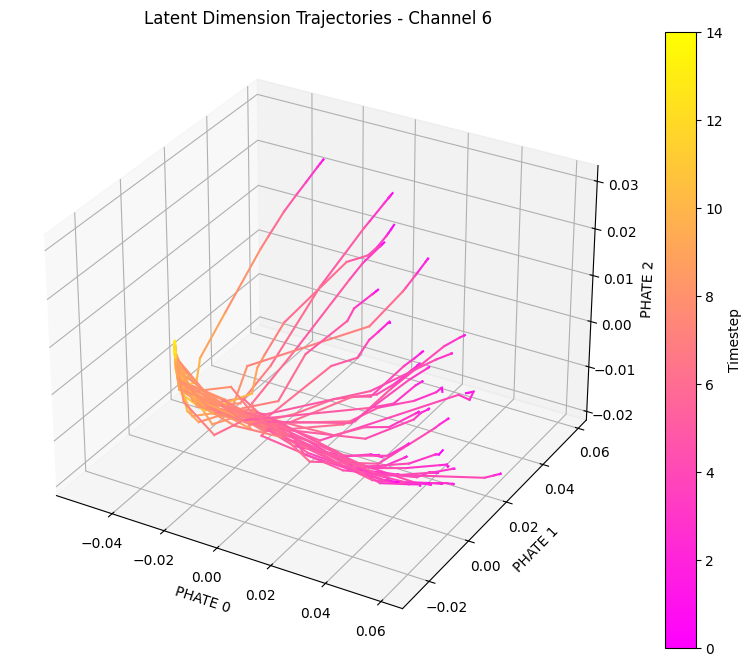

Running PHATE for channel 7...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.16 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 0.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.19 seconds.
Calculated PHATE in 1.47 seconds.


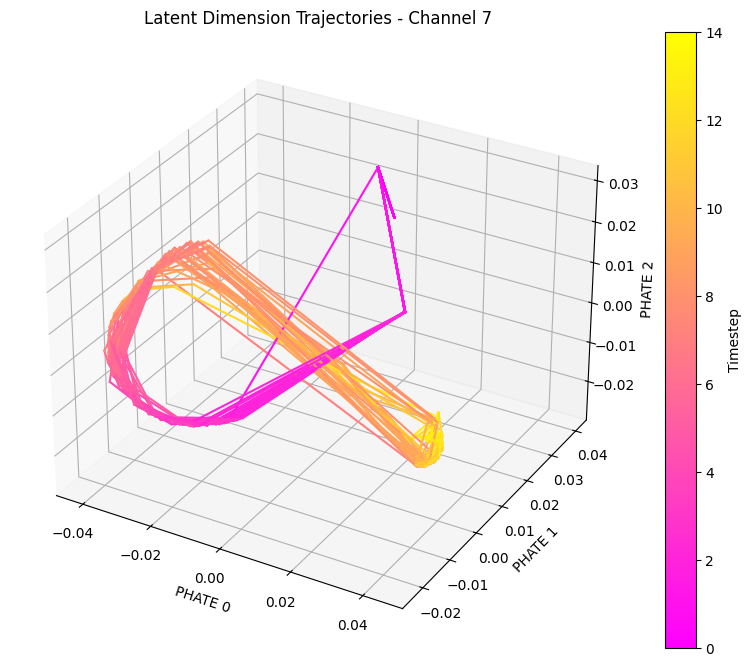

In [9]:
import numpy as np
import phate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: data shape [n_samples, n_ts, n_channels, H, W]
data = all_Z
n_samples, n_ts, n_channels, H, W = data.shape

for c in range(n_channels):
    print(f"Running PHATE for channel {c}...")
    
    # ---- Extract single channel ----
    channel_data = data[:, :, c, :, :]   # shape [n_samples, n_ts, H, W]
    
    # ---- Reshape for PHATE ----
    Z = channel_data.reshape(n_samples * n_ts, -1)   # [n_samples*n_ts, H*W]
    
    # ---- Run PHATE ----
    phate_op = phate.PHATE(n_components=3)
    Z_phate = phate_op.fit_transform(Z)   # [n_samples*n_ts, 3]
    
    # ---- Organize back into trajectories ----
    Z_phate = Z_phate.reshape(n_samples, n_ts, 3)
    
    # ---- Plot trajectories ----
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    # Color by timestep
    colors = plt.cm.spring(np.linspace(0, 1, n_ts))
    
    for i in range(n_samples):
        traj = Z_phate[i]
        for t in range(n_ts - 1):
            ax.plot(
                traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2],
                color=colors[t]
            )
    
    # Make a colorbar for timesteps
    sm = plt.cm.ScalarMappable(cmap="spring", norm=plt.Normalize(vmin=0, vmax=n_ts-1))
    cbar = plt.colorbar(sm, ax=ax)  
    cbar.set_label("Timestep")
    
    ax.set_xlabel("PHATE 0")
    ax.set_ylabel("PHATE 1")
    ax.set_zlabel("PHATE 2")
    ax.set_title(f"Latent Dimension Trajectories - Channel {c}")
    
    plt.show()


Running PHATE for channel 0...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.18 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.23 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 0.09 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.29 seconds.
Calculated PHATE in 2.65 seconds.
Running PHATE for channel 1...
Calculating PHATE...
  Running PHATE on 495 observations and 2048 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.13 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph

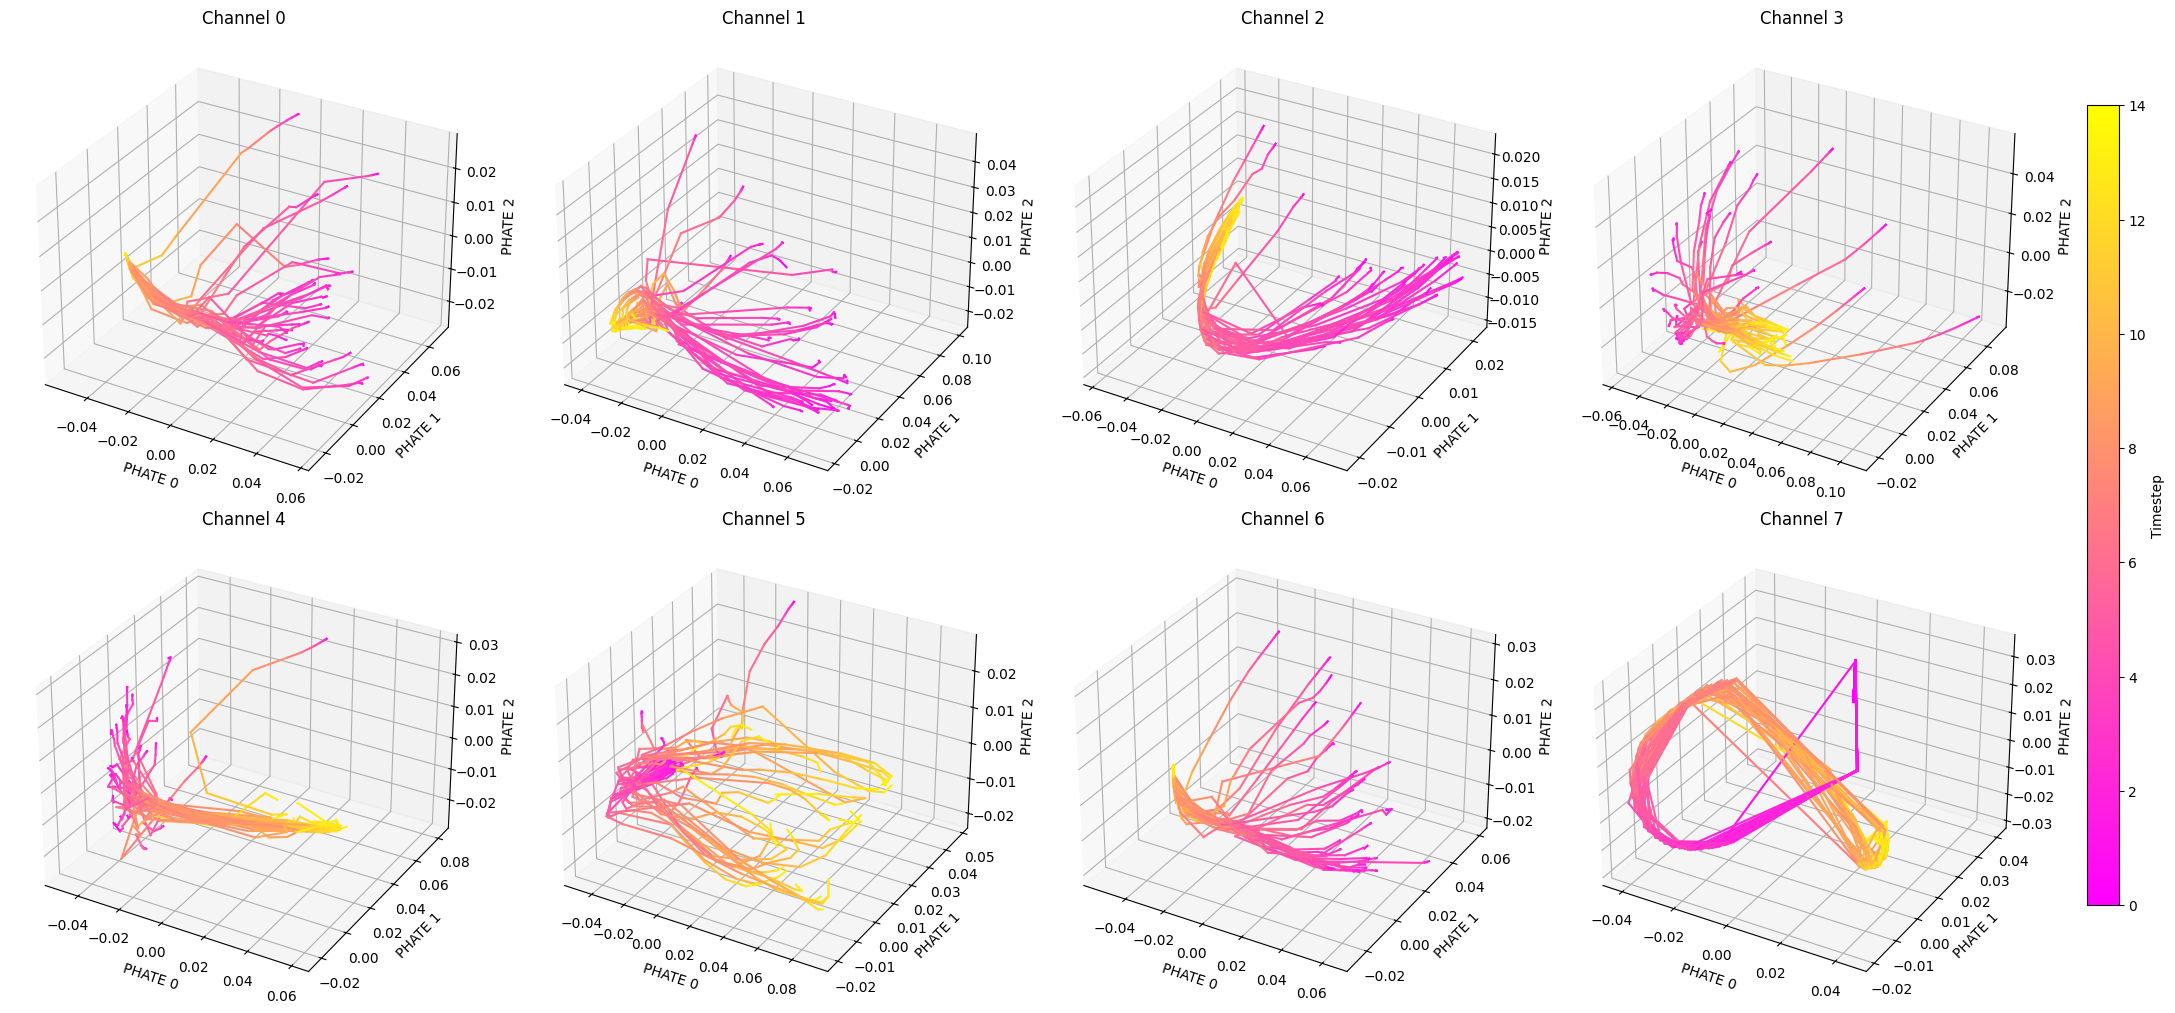

In [12]:
import numpy as np
import phate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: data shape [n_samples, n_ts, n_channels, H, W]
data = all_Z
n_samples, n_ts, n_channels, H, W = data.shape

# Use constrained_layout to handle spacing
fig = plt.figure(figsize=(22, 10), constrained_layout=True)
subfigs = fig.subfigures(1, 2, width_ratios=[20, 1])  # left for plots, right for colorbar

# Create the 2x4 grid on the left subfigure
axs = subfigs[0].subplots(2, 4, subplot_kw={'projection': '3d'})

for c, ax in enumerate(axs.flat):
    print(f"Running PHATE for channel {c}...")
    
    # ---- Extract single channel ----
    channel_data = data[:, :, c, :, :]   # [n_samples, n_ts, H, W]
    
    # ---- Reshape for PHATE ----
    Z = channel_data.reshape(n_samples * n_ts, -1)   # [n_samples*n_ts, H*W]
    
    # ---- Run PHATE ----
    phate_op = phate.PHATE(n_components=3)
    Z_phate = phate_op.fit_transform(Z)   # [n_samples*n_ts, 3]
    
    # ---- Organize back into trajectories ----
    Z_phate = Z_phate.reshape(n_samples, n_ts, 3)
    
    # Color by timestep
    colors = plt.cm.spring(np.linspace(0, 1, n_ts))
    
    for i in range(n_samples):
        traj = Z_phate[i]
        for t in range(n_ts - 1):
            ax.plot(
                traj[t:t+2, 0], traj[t:t+2, 1], traj[t:t+2, 2],
                color=colors[t]
            )
    
    ax.set_xlabel("PHATE 0")
    ax.set_ylabel("PHATE 1")
    ax.set_zlabel("PHATE 2")
    ax.set_title(f"Channel {c}")

# Create an Axes in the right subfigure for the colorbar
cax = subfigs[1].add_axes([0.05, 0.1, 0.3, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap="spring", norm=plt.Normalize(vmin=0, vmax=n_ts-1))
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Timestep")

plt.show()
